<a href="https://colab.research.google.com/github/CodeChef-1/comp215/blob/main/labs/lab04-more_classes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

COMP 215 - LAB 4
----------------
#### Name(s):
#### Date:

By the end of this lab you should be able to:
  * use composition and inheritance in a `class` to categorize related information


During this lab, you will be introduced to the following:
  * something, something



## Near Earth Objects (with more classes)

We'll continue working with Near Earth Object data using NASA's API: https://api.nasa.gov/.  In Lab 3 we defined an Asteroid class that contained a simple data structure.  In this lab, we will be Here's a brief review from Lab 2 on how to use the API.  

In [2]:
# import necessary modules
import datetime, json, requests
from pprint import pprint

### Review: make an API query

Here's a query that gets the record for a single NEO that recently passed by.

In [3]:
#API_KEY = 'DEMO_KEY'  # substitute your API key here
API_KEY = 'QMU73gySBTeUk6FVRje8eMwNOFfI1FZOwRtlf0Xo'

def get_neos(start_date):
    """ Return a list of NEO for the week starting at start_date """
    url = f'https://api.nasa.gov/neo/rest/v1/feed?start_date={start_date}&api_key={API_KEY}'
    # Fetch last week's NEO feed
    response = requests.request("GET", url, headers={}, data={})
    data = json.loads(response.text)
    #pprint(data)
    print(f'{data["element_count"]} Near Earth Objects found for week of {start_date}')
    return [neo for dated_records in data['near_earth_objects'].values() for neo in dated_records ]

def get_neo(id):
    """ Return a NEO record for the given id """
    url = f'https://api.nasa.gov/neo/rest/v1/neo/{id}?api_key={API_KEY}'
    response = requests.request("GET", url, headers={}, data={})
    return json.loads(response.text)

week_start = '2023-01-15'
neos = get_neos(week_start)
assert len(neos) > 0, f'Oh oh!  No NEOs found for {week_start}'
neo = get_neo(neos[-1]['id'])  # get the very latest NEO
print(f"Record for NEO ID {neos[-1]['id']} is:")
#pprint(neo)

117 Near Earth Objects found for week of 2023-01-15
Record for NEO ID 54339874 is:


## Exercise 1: Define a CloseApproach class

Each NEO record comes with a list of `close_approach_data`, where each record in this list represents a single “close approach” to another orbiting body.
1. Develop a class named `CloseApproach` to represent a single close approach record.  State variables are

        neo (refrence to related NEO object)
        orbiting body (str)
        approach date (datetime object!)
        miss distance (float - choose units, document it, and be consistent!)
        relative velocity (ditto)
  
2. Define a "Factory" class method to construct a `CloseApproach` object from one close approach data record (a dictionary object). This method takes a `neo` object as input for the NEO to which the close approach data belongs. Remember to parse the date/time string into a datetime object.

In [5]:
from datetime import datetime

class CloseApproach:

    def __init__(self, neo, orbiting_body, approach_date, miss_distance, relative_velocity):
        self.neo = neo
        self.orbiting_body = orbiting_body
        self.approach_date = approach_date
        self.miss_distance = miss_distance  # in kilometers
        self.relative_velocity = relative_velocity  # in kilometers per second

    @classmethod
    def from_dict(cls, neo):
        #pprint(neo)
        approach_data = neo[0]
        approach_date_str = approach_data['close_approach_date']
        approach_date = datetime.strptime(approach_date_str, '%Y-%m-%d') # Use datetime.strptime
        miss_distance_km = float(approach_data['miss_distance']['kilometers'])
        relative_velocity_km_s = float(approach_data['relative_velocity']['kilometers_per_second'])

        return cls(neo, approach_data['orbiting_body'], approach_date, miss_distance_km, relative_velocity_km_s)

    def __repr__(self) -> str:
        return f"CloseApproach(neo={self.neo}, orbiting_body={self.orbiting_body}, approach_date={self.approach_date}, miss_distance={self.miss_distance}, relative_velocity={self.relative_velocity})"

# Example usage

neo_data_example = get_neo(54339874)
test_approach = CloseApproach.from_dict(neo_data_example['close_approach_data'])
print(repr(test_approach))
print(test_approach.approach_date)
print(test_approach.miss_distance)
#code did not function properly so i let gemini correct some mistakes

CloseApproach(neo=[{'close_approach_date': '1949-07-04', 'close_approach_date_full': '1949-Jul-04 22:19', 'epoch_date_close_approach': -646710060000, 'relative_velocity': {'kilometers_per_second': '20.4193538659', 'kilometers_per_hour': '73509.6739172087', 'miles_per_hour': '45676.0526626122'}, 'miss_distance': {'astronomical': '0.419726307', 'lunar': '163.273533423', 'kilometers': '62790161.51016609', 'miles': '39015997.166588442'}, 'orbiting_body': 'Earth'}, {'close_approach_date': '1950-08-07', 'close_approach_date_full': '1950-Aug-07 12:47', 'epoch_date_close_approach': -612270780000, 'relative_velocity': {'kilometers_per_second': '11.1844693277', 'kilometers_per_hour': '40264.0895797362', 'miles_per_hour': '25018.5394391422'}, 'miss_distance': {'astronomical': '0.2356866436', 'lunar': '91.6821043604', 'kilometers': '35258219.870009132', 'miles': '21908441.9192727416'}, 'orbiting_body': 'Earth'}, {'close_approach_date': '1951-01-22', 'close_approach_date_full': '1951-Jan-22 19:42',

## Exercise 2: Add list of CloseApproach objects to the Asteroid

Define an `Asteroid` class, like you did in Lab 3, but give the `Asteroid` list of “close approaches”.  This is called *composition* because each Asteroid object will be *composed* of CloseApproach objects (plus some other things).  There is bit of a catch-22 here because we need the `Asteroid` to construct the `CloseApproach` objects. The first two steps deal with that:

1. Add an instance variable to your Asteroid class with a default value of an empty list:

    ```
    close_approaches:list = []
    ```
      
2. In the Asteroid `from_NEO` factory, use a list comprehension to build the list of `CloseApproach` objects for the Asteroid instance, and then set the instance's `close_approaches` variable before returning it. Setting the value of an object's instance variables from outside the class is generally frowned upon - this is why we make the factory a method of the class itself.

3. Add a method to `Asteroid` to return the `CloseApproach` object for the nearest miss (ie. smallest `missed_distance`):
    ```
    def nearest_miss(self):
        ...
    ```

4. Add a method to the Asteroid class, `closest_earth_approach`, that returns the CloseApproach object that represents the closest approach the Asteroid makes to Earth.
    ```
    def closest_earth_approach(self):
        ...
      
    ```

Write some test code to demonstrate these new features.

In [49]:
'''
class Asteroid:

    close_approaches: list = []

    def __init__(self, CloseApproach, name:str, diameter:float, hazardous:bool, nearmiss):
        self.name = name
        self.diameter = diameter
        self.hazardous = hazardous
        self.close_approaches = []
        self.nearmiss = nearmiss

    @classmethod
    def from_neo(cls, neoid):
      # Using CloseApproach.from_dict for composition
      neo_data = get_neo(neoid)
      #pprint(neo_data)
      cls.close_approaches = [approach for approach in neo_data['close_approach_data']]
      #pprint((cls.close_approaches))
      return cls.close_approaches

    def nearest_miss(self):
      pprint(self.close_approaches[0])
      nearmiss = min(self.close_approaches['miss_distance']['kilometers'])
      return nearmiss

    def closest_earth_approach(self):
      return min(self.close_approaches, key=lambda x: x.approach_date)

   #gemini showed me what the lambda func does, it makes a small unamed function, this should only be used in very small segments of code

#neo_data_example = get_neo(54339874)
test_approach = Asteroid.from_neo(54339874) #create instance of the Asteroid class
#print(test_approach)
test_approach.nearest_miss()
#help(Asteroid)

#neo_data_example = get_neo(54339874)
#testcase = Asteroid.nearest_miss(neo_data_example)
'''


AttributeError: 'list' object has no attribute 'nearest_miss'

In [55]:
'''this is the gemini corrected version'''
class Asteroid:
    close_approaches: list = []

    def __init__(self, CloseApproach, name: str, diameter: float, hazardous: bool, nearmiss):
        self.name = name
        self.diameter = diameter
        self.hazardous = hazardous
        self.close_approaches = []
        self.nearmiss = nearmiss

    @classmethod
    def from_neo(cls, neoid):
        # Using CloseApproach.from_dict for composition
        neo_data = get_neo(neoid)
        asteroid_instance = cls(None, neo_data['name'], neo_data['estimated_diameter']['kilometers']['estimated_diameter_max'],
                               neo_data['is_potentially_hazardous_asteroid'], None)
        asteroid_instance.close_approaches = [CloseApproach.from_dict([approach]) for approach in neo_data['close_approach_data']]
        return asteroid_instance  # Return the instance

    def nearest_miss(self):
        nearmiss = min(self.close_approaches, key=lambda x: x.miss_distance)
        return nearmiss.miss_distance

    def closest_earth_approach(self):
        earth_approaches = [approach for approach in self.close_approaches if approach.orbiting_body == 'Earth']
        if not earth_approaches:
            return None
        return min(earth_approaches, key=lambda x: x.miss_distance)

#neo_data_example = get_neo(54339874)
test_approach = Asteroid.from_neo(54339874) #create instance of the Asteroid class
#print(test_approach)
#test_approach.nearest_miss()
test_approach.closest_earth_approach()
#help(Asteroid)

CloseApproach(neo=[{'close_approach_date': '2011-07-25', 'close_approach_date_full': '2011-Jul-25 00:38', 'epoch_date_close_approach': 1311554280000, 'relative_velocity': {'kilometers_per_second': '12.2933988847', 'kilometers_per_hour': '44256.2359849621', 'miles_per_hour': '27499.1039652116'}, 'miss_distance': {'astronomical': '0.0238528057', 'lunar': '9.2787414173', 'kilometers': '3568328.926243859', 'miles': '2217256.7792048942'}, 'orbiting_body': 'Earth'}], orbiting_body=Earth, approach_date=2011-07-25 00:00:00, miss_distance=3568328.926243859, relative_velocity=12.2933988847)

## Exercise 3: Plot the Closest Approaches

Write a function that takes an Asteroid object as a parameter and makes a timeline plot of close approaches.  You may wish to use the `matplotlib.pyplot` `plot` object.  Here is an example of a timeline plot for the asteroid with neo id '54339874'

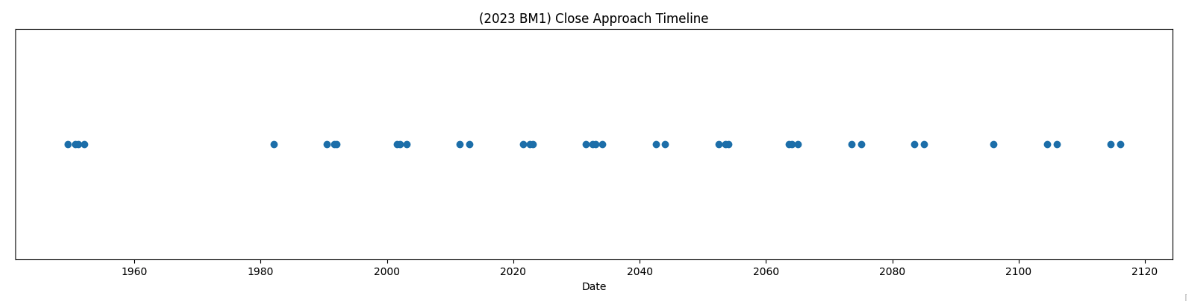

ValueError: x and y must have same first dimension, but have shapes (37,) and (1,)

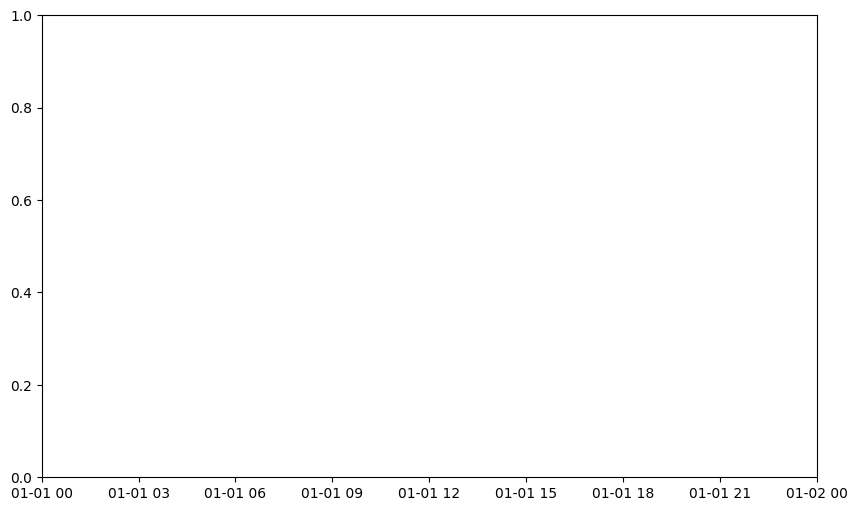

In [71]:
import matplotlib.pyplot as plt
from datetime import datetime

def plot_close_approaches(asteroid):

    dates = []
    # Access close_approaches directly from the asteroid object
    approach_list = asteroid.close_approaches
    for approach in approach_list:
        if approach:
            dates.append(approach.approach_date)  # Use approach_date attribute


    plt.figure(figsize=(10, 6))
    plt.plot(dates, 10)
    plt.xlabel("Date")
    # Access neo_id from approach.neo (replace if neo_id is stored elsewhere)
    plt.title(f"close approach timeline of {approach_list[0]['neo_reference_id']}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid(True)
    plt.show()

plot_close_approaches(test_approach)

## Challenge - Take your skills to the next level...

 With these data structures in place, we can now start answering all kinds of interesting questions about a single Asteroid or a set of Asteroids.  
Here’s a couple ideas to try:



* write a **function** named `most_dangerous_approach`, that takes a date range and returns a single “potentially hazardous” Asteroid object that makes the closest approach to Earth in within that range.  Your algorithm will ultimately need to:
    * grab the list of NEO’s for the given date range;
    * use a list comprehension to build the list of Asteroid objects for the NEO’s returned
    * use a list comprehension to filter  potentially hazardous Asteroids only;
    * use a list comprehension to map each Asteroid to its  closest_earth_approach
    * apply Python’s min function to identify the Asteroid with the closest_earth_approach

You may want to decompose some of these steps into smaller functions.
* add a method to the Asteroid class, estimated_mass, that computes an estimate of the Asteroid’s mass based on its diameter.  This is a model – state your assumptions.
* add a method to the CloseApproach class, impact_force,  that estimates the force of impact if the Asteroid hit the orbiting object.  Again, this is a model, state your assumptions.

In [ ]:
# Ex. 5 (challenge) your code here